In [1]:
from fastai.vision.all import *
import pandas as pd
import cam
import util

model_dir = Path('../saves/auc_maximization')

In [2]:
dls, labels = util.chexpert_data_loader(bs=16)

# Base model

In [3]:
chexpert_learner_base = util.ChexpertLearner(dls, densenet121, n_out=len(labels),
                                        loss_func=BCEWithLogitsLossFlat(),
                                        metrics=[RocAucMulti(average=None),
                                                 RocAucMulti(average='weighted')])

lr_min/10: 0.010000000149011612, lr_steep: 0.05754399299621582, base_lr: 0.05754399299621582


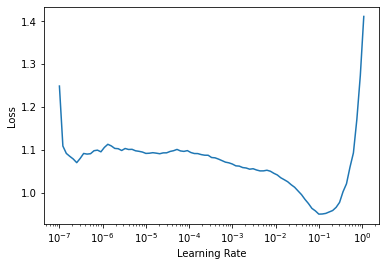

In [4]:
chexpert_learner_base.find_lr()

epoch,train_loss,valid_loss,roc_auc_score,roc_auc_score,time
0,0.365233,1.219114,[0.8218835 0.5331886 0.72920755 0.67264035 0.66226325 0.76158942 0.59128133 0.62793562 0.57675625 0.67822908 0.81389041 0.68599293 0.48936005 0.79443186],0.726946,31:56


Better model found at epoch 0 with valid_loss value: 1.2191137075424194.


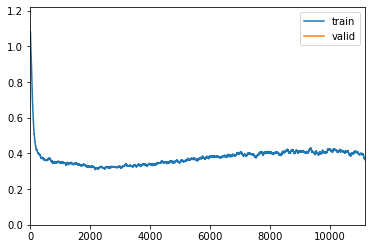

epoch,train_loss,valid_loss,roc_auc_score,roc_auc_score,time
0,0.339502,0.531477,[0.8223498 0.55025102 0.80354567 0.66931918 0.63909417 0.78641657 0.66411353 0.63666264 0.61683463 0.66820693 0.83437836 0.58484311 0.64246809 0.81944628],0.748163,37:15
1,0.323468,0.539051,[0.84878922 0.58556396 0.82604493 0.70079609 0.69258723 0.81430757 0.68810767 0.70558456 0.62680025 0.80130871 0.85666442 0.70899608 0.64481063 0.85055882],0.780204,37:00
2,0.294128,0.447500,[0.86285201 0.63398286 0.84592491 0.7184037 0.72788647 0.83416874 0.71634902 0.73291026 0.66878649 0.82666951 0.87318174 0.74990316 0.68947687 0.8675907 ],0.801595,37:25


Better model found at epoch 0 with valid_loss value: 0.5314769744873047.


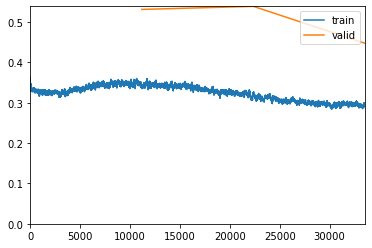

Better model found at epoch 2 with valid_loss value: 0.447499543428421.


In [5]:
chexpert_learner_base.learn_model(use_saved=False, epochs=3)

In [6]:
# Save the body of the trained base model
torch.save(chexpert_learner_base.learn.model[0].state_dict(), model_dir/'chexpert_learner_base.pth')

# DAM model

In [3]:
# Create a new densenet121 model
model_dam = cnn_learner(dls, densenet121, n_out=len(labels), y_range=[0,1]).model

# Replace the body of new model with the body from the base model
model_dam[0].load_state_dict(torch.load(model_dir/'chexpert_learner_base.pth'))

# Set all parameters to require grad
for param in model_dam.parameters():
    param.requires_grad = True

# Move model to cuda
model_dam = model_dam.cuda()

In [4]:
from libauc.losses import AUCMLoss
from libauc.optimizers import PESG

lr = 0.1
gamma = 500
weight_decay = 0
margin = 1.0

loss_func = AUCMLoss()
opt_func = PESG(model_dam, a=loss_func.a, b=loss_func.b, alpha=loss_func.alpha, lr=lr, gamma=gamma, margin=margin)

In [5]:
from sklearn.metrics import roc_auc_score

def eval(model, dls):
    model.eval()
    test_pred = []
    test_true = [] 
    for j, (test_data, test_targets) in enumerate(dls.valid):
        y_pred = model(test_data)
        test_pred.append(y_pred.cpu().detach().numpy())
        test_true.append(test_targets.cpu().detach().numpy())
    test_true = np.concatenate(test_true)
    test_true[test_true < 0.5] = 0
    test_true[test_true >= 0.5] = 1
    test_pred = np.concatenate(test_pred)
    return roc_auc_score(test_true, test_pred, average='weighted')

In [6]:
import time
import pickle

def train(model, dls, loss_func, opt_func, max_epoch=3, checkpoint=None):
    # Load checkpoint if available
    if checkpoint != None:
        model_checkpoint = torch.load(checkpoint)
        model.load_state_dict(model_checkpoint['state_dict'])
        opt_func.load_state_dict(model_checkpoint['optimizer'])
    
    # Train model
    max_auc = 0
    
    for epoch in range(max_epoch):

        train_pred = []
        train_true = []
        model.train()    
        for i, (data, targets) in enumerate(dls.train):
            opt_func.zero_grad()
            y_pred = model(data)
            loss = loss_func(y_pred, targets)
            loss.backward(retain_graph=True)
            opt_func.step()

            train_pred.append(y_pred.cpu().detach().numpy())
            train_true.append(targets.cpu().detach().numpy())
            
        opt_func.lr = opt_func.lr/2
        opt_func.update_regularizer()

        train_true = np.concatenate(train_true)
        train_true[train_true < 0.5] = 0
        train_true[train_true >= 0.5] = 1
        train_pred = np.concatenate(train_pred)
        pickle.dump({'train_true': train_true, 'train_pred': train_pred}, open(model_dir/f'train_metrics_{epoch}.p', 'wb'))
        train_auc = roc_auc_score(train_true, train_pred, average='weighted') 
        
        # Eval model
        val_auc =  eval(model, dls)

        # print results
        print("epoch: {}, train_loss: {:4f}, train_auc:{:4f}, test_auc:{:4f}, lr:{:4f}".format(epoch, loss.item(), train_auc, val_auc, opt_func.lr ))
        
        # Save checkpoint
        if val_auc > max_auc:
            max_auc = val_auc
            torch.save({
                'epoch': epoch+1,
                'best_auc': val_auc,
                'state_dict': model.state_dict()
            }, model_dir/f"m-epoch {epoch+1}-{time.strftime('%Y_%h_%d-%H_%M_%S')}.pth.tar")

In [7]:
eval(model_dam, dls)

0.5126817785233931

In [8]:
train(model_dam, dls, loss_func, opt_func)

Update Regularizer @ T=11182!
epoch: 0, train_loss: -0.018825, train_auc:0.710747, test_auc:0.731226, lr:0.050000
Update Regularizer @ T=11182!
epoch: 1, train_loss: -0.008057, train_auc:0.707561, test_auc:0.762300, lr:0.025000
Update Regularizer @ T=11182!
epoch: 2, train_loss: -0.004776, train_auc:0.712496, test_auc:0.770628, lr:0.012500
